In [ ]:
#参考代码：
https://github.com/pandas-dev/pandas/blob/v0.25.1/pandas/core/reshape/tile.py
https://blog.csdn.net/weixin_40683253/article/details/81780910

In [28]:
import pandas as pd
import numpy as np

In [8]:
datafile = r'C:\Users\Tianh\Desktop\iris_data.csv'
# df = pd.read_csv(r'C:\Users\Tianh\Desktop\iris_data.csv',header=None)
data = pd.read_csv(datafile,header=None)
data = data.iloc[:,1]
k = 5

In [9]:
data.head()

0    3.5
1    3.0
2    3.2
3    3.1
4    3.6
Name: 1, dtype: float64

In [10]:
data

0      3.5
1      3.0
2      3.2
3      3.1
4      3.6
      ... 
145    3.0
146    2.5
147    3.0
148    3.4
149    3.0
Name: 1, Length: 150, dtype: float64

In [11]:
#等宽离散

In [12]:
d1 = pd.cut(data,k,labels = range(k))

In [13]:

def cluster_plot(d,k):
    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.figure(figsize = (12,4))
    for j in range(0,k):
        plt.plot(data[d==j], [j for i in d[d==j]],'o')
        
    plt.ylim(-0.5, k-0.5)
    return plt

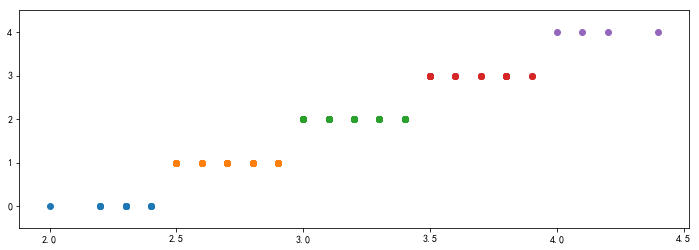

In [15]:
cluster_plot(d1, k).show()

In [16]:
#等频离散

In [19]:
data = data.drop_duplicates(keep=False)
w = [1.0*i/k for i in range(k+1)]
w = data.describe(percentiles = w)[4:4+k+1]
w[0] = w[0]*(1-1e-10)
d2 = pd.cut(data, w, labels = range(k))

In [22]:
def cluster_plot(d,k):
    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.figure(figsize = (12,4))
    for j in range(0,k):
        plt.plot(data[d==j], [j for i in d[d==j]],'o')
        
    plt.ylim(-0.5, k-0.5)
    return plt

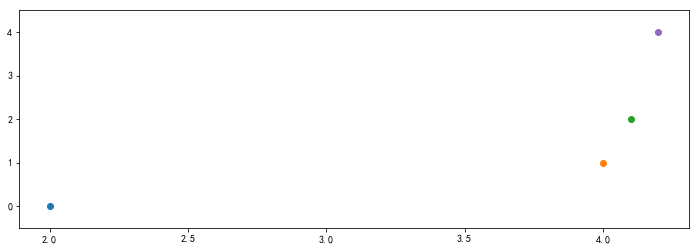

In [23]:
cluster_plot(d2, k).show()

In [32]:
#附录:pandas.cut()源码

In [38]:
from functools import partial

from pandas._libs.lib import infer_dtype

from pandas.core.dtypes.common import (
    _NS_DTYPE,
    ensure_int64,
    is_categorical_dtype,
    is_datetime64_dtype,
    is_datetime64tz_dtype,
    is_datetime_or_timedelta_dtype,
    is_integer,
    is_scalar,
    is_timedelta64_dtype,
)
from pandas.core.dtypes.missing import isna

from pandas import (
    Categorical,
    Index,
    Interval,
    IntervalIndex,
    Series,
    Timedelta,
    Timestamp,
    to_datetime,
    to_timedelta,
)
import pandas.core.algorithms as algos
import pandas.core.nanops as nanops

In [47]:
def _preprocess_for_cut(x):
    """
    handles preprocessing for cut where we convert passed
    input to array, strip the index information and store it
    separately
    """
    x_is_series = isinstance(x, Series)
    series_index = None
    name = None

    if x_is_series:
        series_index = x.index
        name = x.name

    # Check that the passed array is a Pandas or Numpy object
    # We don't want to strip away a Pandas data-type here (e.g. datetimetz)
    ndim = getattr(x, "ndim", None)
    if ndim is None:
        x = np.asarray(x)
    if x.ndim != 1:
        raise ValueError("Input array must be 1 dimensional")

    return x_is_series, series_index, name, x


In [48]:
def _coerce_to_type(x):
    """
    if the passed data is of datetime/timedelta type,
    this method converts it to numeric so that cut method can
    handle it
    """
    dtype = None

    if is_datetime64tz_dtype(x):
        dtype = x.dtype
    elif is_datetime64_dtype(x):
        x = to_datetime(x)
        dtype = np.dtype("datetime64[ns]")
    elif is_timedelta64_dtype(x):
        x = to_timedelta(x)
        dtype = np.dtype("timedelta64[ns]")

    if dtype is not None:
        # GH 19768: force NaT to NaN during integer conversion
        x = np.where(x.notna(), x.view(np.int64), np.nan)

    return x, dtype

In [51]:
def _bins_to_cuts(
    x,
    bins,
    right=True,
    labels=None,
    precision=3,
    include_lowest=False,
    dtype=None,
    duplicates="raise",
):

    if duplicates not in ["raise", "drop"]:
        raise ValueError(
            "invalid value for 'duplicates' parameter, "
            "valid options are: raise, drop"
        )

    if isinstance(bins, IntervalIndex):
        # we have a fast-path here
        ids = bins.get_indexer(x)
        result = algos.take_nd(bins, ids)
        result = Categorical(result, categories=bins, ordered=True)
        return result, bins

    unique_bins = algos.unique(bins)
    if len(unique_bins) < len(bins) and len(bins) != 2:
        if duplicates == "raise":
            raise ValueError(
                "Bin edges must be unique: {bins!r}.\nYou "
                "can drop duplicate edges by setting "
                "the 'duplicates' kwarg".format(bins=bins)
            )
        else:
            bins = unique_bins

    side = "left" if right else "right"
    ids = ensure_int64(bins.searchsorted(x, side=side))

    if include_lowest:
        ids[x == bins[0]] = 1

    na_mask = isna(x) | (ids == len(bins)) | (ids == 0)
    has_nas = na_mask.any()

    if labels is not False:
        if labels is None:
            labels = _format_labels(
                bins, precision, right=right, include_lowest=include_lowest, dtype=dtype
            )
        else:
            if len(labels) != len(bins) - 1:
                raise ValueError(
                    "Bin labels must be one fewer than " "the number of bin edges"
                )
        if not is_categorical_dtype(labels):
            labels = Categorical(labels, categories=labels, ordered=True)

        np.putmask(ids, na_mask, 0)
        result = algos.take_nd(labels, ids - 1)

    else:
        result = ids - 1
        if has_nas:
            result = result.astype(np.float64)
            np.putmask(result, na_mask, np.nan)

    return result, bins

In [53]:
def _format_labels(bins, precision, right=True, include_lowest=False, dtype=None):
    """ based on the dtype, return our labels """

    closed = "right" if right else "left"

    if is_datetime64tz_dtype(dtype):
        formatter = partial(Timestamp, tz=dtype.tz)
        adjust = lambda x: x - Timedelta("1ns")
    elif is_datetime64_dtype(dtype):
        formatter = Timestamp
        adjust = lambda x: x - Timedelta("1ns")
    elif is_timedelta64_dtype(dtype):
        formatter = Timedelta
        adjust = lambda x: x - Timedelta("1ns")
    else:
        precision = _infer_precision(precision, bins)
        formatter = lambda x: _round_frac(x, precision)
        adjust = lambda x: x - 10 ** (-precision)

    breaks = [formatter(b) for b in bins]
    labels = IntervalIndex.from_breaks(breaks, closed=closed)

    if right and include_lowest:
        # we will adjust the left hand side by precision to
        # account that we are all right closed
        v = adjust(labels[0].left)

        i = IntervalIndex([Interval(v, labels[0].right, closed="right")])
        labels = i.append(labels[1:])

    return labels

In [49]:
def cut(
    x,
    bins,
    right=True,
    labels=None,
    retbins=False,
    precision=3,
    include_lowest=False,
    duplicates="raise",
):
    # for handling the cut for datetime and timedelta objects
    x_is_series, series_index, name, x = _preprocess_for_cut(x)
    x, dtype = _coerce_to_type(x)

    if not np.iterable(bins):
        if is_scalar(bins) and bins < 1:
            raise ValueError("`bins` should be a positive integer.")

        try:  # for array-like
            sz = x.size
        except AttributeError:
            x = np.asarray(x)
            sz = x.size

        if sz == 0:
            raise ValueError("Cannot cut empty array")

        rng = (nanops.nanmin(x), nanops.nanmax(x))
        mn, mx = [mi + 0.0 for mi in rng]

        if np.isinf(mn) or np.isinf(mx):
            # GH 24314
            raise ValueError(
                "cannot specify integer `bins` when input data " "contains infinity"
            )
        elif mn == mx:  # adjust end points before binning
            mn -= 0.001 * abs(mn) if mn != 0 else 0.001
            mx += 0.001 * abs(mx) if mx != 0 else 0.001
            bins = np.linspace(mn, mx, bins + 1, endpoint=True)
        else:  # adjust end points after binning
            bins = np.linspace(mn, mx, bins + 1, endpoint=True)
            adj = (mx - mn) * 0.001  # 0.1% of the range
            if right:
                bins[0] -= adj
            else:
                bins[-1] += adj

    elif isinstance(bins, IntervalIndex):
        if bins.is_overlapping:
            raise ValueError("Overlapping IntervalIndex is not accepted.")

    else:
        if is_datetime64tz_dtype(bins):
            bins = np.asarray(bins, dtype=_NS_DTYPE)
        else:
            bins = np.asarray(bins)
        bins = _convert_bin_to_numeric_type(bins, dtype)

        # GH 26045: cast to float64 to avoid an overflow
        if (np.diff(bins.astype("float64")) < 0).any():
            raise ValueError("bins must increase monotonically.")

    fac, bins = _bins_to_cuts(
        x,
        bins,
        right=right,
        labels=labels,
        precision=precision,
        include_lowest=include_lowest,
        dtype=dtype,
        duplicates=duplicates,
    )

    return _postprocess_for_cut(
        fac, bins, retbins, x_is_series, series_index, name, dtype
    )

In [54]:
def _round_frac(x, precision):
    """
    Round the fractional part of the given number
    """
    if not np.isfinite(x) or x == 0:
        return x
    else:
        frac, whole = np.modf(x)
        if whole == 0:
            digits = -int(np.floor(np.log10(abs(frac)))) - 1 + precision
        else:
            digits = precision
        return np.around(x, digits)

In [55]:
def _infer_precision(base_precision, bins):
    """Infer an appropriate precision for _round_frac
    """
    for precision in range(base_precision, 20):
        levels = [_round_frac(b, precision) for b in bins]
        if algos.unique(levels).size == bins.size:
            return precision
    return base_precision  # default

In [58]:
def _convert_bin_to_datelike_type(bins, dtype):
    """
    Convert bins to a DatetimeIndex or TimedeltaIndex if the original dtype is
    datelike
    Parameters
    ----------
    bins : list-like of bins
    dtype : dtype of data
    Returns
    -------
    bins : Array-like of bins, DatetimeIndex or TimedeltaIndex if dtype is
           datelike
    """
    if is_datetime64tz_dtype(dtype):
        bins = to_datetime(bins.astype(np.int64), utc=True).tz_convert(dtype.tz)
    elif is_datetime_or_timedelta_dtype(dtype):
        bins = Index(bins.astype(np.int64), dtype=dtype)
    return bins

In [59]:
cut(np.array([1, 7, 5, 4, 6, 3]), 3)

[(0.994, 3.0], (5.0, 7.0], (3.0, 5.0], (3.0, 5.0], (5.0, 7.0], (0.994, 3.0]]
Categories (3, interval[float64]): [(0.994, 3.0] < (3.0, 5.0] < (5.0, 7.0]]

In [60]:
cut(np.array([1, 7, 5, 4, 6, 3]), 3, retbins=True)

([(0.994, 3.0], (5.0, 7.0], (3.0, 5.0], (3.0, 5.0], (5.0, 7.0], (0.994, 3.0]]
 Categories (3, interval[float64]): [(0.994, 3.0] < (3.0, 5.0] < (5.0, 7.0]],
 array([0.994, 3.   , 5.   , 7.   ]))